In [1]:
# scRNA and snRNA integration using scvi-tools
import scvi
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

Global seed set to 0
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will b

In [2]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=80, frameon=True, color_map='viridis_r', dpi_save=600)
palette_d = ['#378C4F', '#7BBC5E', '#E2A7CC', '#D9579B', '#A59ACB', '#006DDBFF', '#7464AA',  '#6DB6FFFF', '#B6DBFFFF', '#F5CDCD', '#924900FF'] # user defined discrete colors

In [3]:
adata_sc = scvi.data.read_h5ad('scRNA_anno.h5ad')

In [4]:
adata_sn = scvi.data.read_h5ad('snRNA_anno.h5ad')

In [10]:
adata_sn

AnnData object with n_obs × n_vars = 89442 × 17654
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'stress_ratio'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [11]:
adata_sc

AnnData object with n_obs × n_vars = 81811 × 16458
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'stress_ratio'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [12]:
adata_sn.obs.patient_id.unique()

['snPNT1', 'snPNT2', 'snPT1', 'snPT2', 'snPT3', ..., 'snPT8', 'snPT9', 'snRT1', 'snRT2', 'snRT3']
Length: 14
Categories (14, object): ['snPNT1', 'snPNT2', 'snPT1', 'snPT2', ..., 'snPT9', 'snRT1', 'snRT2', 'snRT3']

In [8]:
adata = adata_sc.concatenate(adata_sn)

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [9]:
adata.layers['counts'] = adata.X.copy() # preserve counts

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the process, and store the normalized counts

normalizing counts per cell
    finished (0:00:00)


In [11]:
adata

AnnData object with n_obs × n_vars = 171253 × 16294
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'stress_ratio', 'batch'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1'
    uns: 'log1p'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [12]:
adata.obs.celltype.unique()

array(['Hepatocytes', 'Plasma cell', 'Myeloid cell', 'Cycling cell',
       'Endothelial cell', 'B cell', 'T/NK cell', 'CAF', 'Neutrophils'],
      dtype=object)

In [13]:
# select the top 1500 variable genes for data integration
sc.pp.highly_variable_genes(adata, 
                           flavor='seurat_v3', 
                           n_top_genes=1500, 
                           batch_key='sampletype', 
                            layer='counts',
                           subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [16]:
adata.obs

patient_id condition sampletype  nCount_RNA  \
PNT1_TAACCAGCATACACCA-1-0     scPNT1       PNT  scRNA-seq     91754.0   
PNT1_TACCTCGTCCTTCTAA-1-0     scPNT1       PNT  scRNA-seq     33903.0   
PNT1_ATAGACCAGCGGGTAT-1-0     scPNT1       PNT  scRNA-seq     18492.0   
PNT1_CTTTCAACACGATTCA-1-0     scPNT1       PNT  scRNA-seq     17989.0   
PNT1_AGCGTATAGCAGAAAG-1-0     scPNT1       PNT  scRNA-seq     11255.0   
...                              ...       ...        ...         ...   
RT3_TCTCCGAAGTCATACC-1-1       snRT3        RT  snRNA-seq      1195.0   
RT3_GCGGATCGTTGAGTCT-1-1       snRT3        RT  snRNA-seq      1580.0   
RT3_GTTACCCGTGGATGAC-1-1       snRT3        RT  snRNA-seq      1554.0   
RT3_AGAAGCGTCCCGTGTT-1-1       snRT3        RT  snRNA-seq      1712.0   
RT3_CTCTCAGAGAGATCGC-1-1       snRT3        RT  snRNA-seq      1938.0   

                           nFeature_RNA  mt_ratio  ribo_ratio   S.Score  \
PNT1_TAACCAGCATACACCA-1-0          8396  6.402627   15.758704 -0.091475   
PNT1_TACCTCGTCCTTCTAA-1-0          5426  1.430668    7.852366 -0.069337   
PNT1_ATAGACCAGCGGGTAT-1-0          3325  0.533521    8.555035 -0.026358   
PNT1_CTTTCAACACGATTCA-1-0          3118  0.856114    8.614156 -0.113612   
PNT1_AGCGTATAGCAGAAAG-1-0          1939  0.685065    7.826993 -0.061976   
...                                 ...       ...         ...       ...   
RT3_TCTCCGAAGTCATACC-1-1            452  1.972062   15.201315 -0.069032   
RT3_GCGGATCGTTGAGTCT-1-1           1129  0.766962    0.412979 -0.048837   
RT3_GTTACCCGTGGATGAC-1-1           1068  2.726146    0.000000  0.041134   
RT3_AGAAGCGTCCCGTGTT-1-1           1153  3.353829    0.223589  0.100996   
RT3_CTCTCAGAGAGATCGC-1-1           1412  0.412844    0.550459 -0.060910   

                           G2M.Score Phase          celltype  stress_ratio  \
PNT1_TAACCAGCATACACCA-1-0  -0.114883    G1       Hepatocytes     13.126403   
PNT1_TACCTCGTCCTTCTAA-1-0  -0.054674    G1       Plasma cell      8.332596   
PNT1_ATAGACCAGCGGGTAT-1-0  -0.125626    G1       Plasma cell      4.807484   
PNT1_CTTTCAACACGATTCA-1-0  -0.102579    G1       Plasma cell      1.083996   
PNT1_AGCGTATAGCAGAAAG-1-0  -0.082380    G1       Plasma cell      1.021768   
...                              ...   ...               ...           ...   
RT3_TCTCCGAAGTCATACC-1-1   -0.017565    G1       Hepatocytes      0.418410   
RT3_GCGGATCGTTGAGTCT-1-1   -0.092640    G1         T/NK cell      0.189873   
RT3_GTTACCCGTGGATGAC-1-1   -0.092658     S  Endothelial cell      0.000000   
RT3_AGAAGCGTCCCGTGTT-1-1   -0.093497     S  Endothelial cell      0.350467   
RT3_CTCTCAGAGAGATCGC-1-1    0.008544   G2M       Hepatocytes      0.051600   

                          batch  _scvi_batch  _scvi_labels  
PNT1_TAACCAGCATACACCA-1-0     0            0             0  
PNT1_TACCTCGTCCTTCTAA-1-0     0            0             0  
PNT1_ATAGACCAGCGGGTAT-1-0     0            0             0  
PNT1_CTTTCAACACGATTCA-1-0     0            0             0  
PNT1_AGCGTATAGCAGAAAG-1-0     0            0             0  
...                         ...          ...           ...  
RT3_TCTCCGAAGTCATACC-1-1      1            0             0  
RT3_GCGGATCGTTGAGTCT-1-1      1            0             0  
RT3_GTTACCCGTGGATGAC-1-1      1            0             0  
RT3_AGAAGCGTCCCGTGTT-1-1      1            0             0  
RT3_CTCTCAGAGAGATCGC-1-1      1            0             0  

[171253 rows x 15 columns]

In [17]:
# Train a scvi model
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["batch", "patient_id"],
    continuous_covariate_keys=["mt_ratio", "ribo_ratio"]
)

In [18]:
model = scvi.model.SCVI(adata)

In [19]:
model.train(max_epochs=600, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 600/600: 100%|█████████████████████████████████████████████| 600/600 [1:35:05<00:00,  9.02s/it, loss=592, v_num=1]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|█████████████████████████████████████████████| 600/600 [1:35:05<00:00,  9.51s/it, loss=592, v_num=1]


In [20]:
adata.obsm['X_scvi'] = model.get_latent_representation()

In [21]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=10e4)

In [26]:
adata.obsm['X_scvi'].shape

(171253, 10)

In [18]:
# plot the uncorrected cell embeddings
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
sc.tl.umap(adata, min_dist=0.3)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:37)


/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


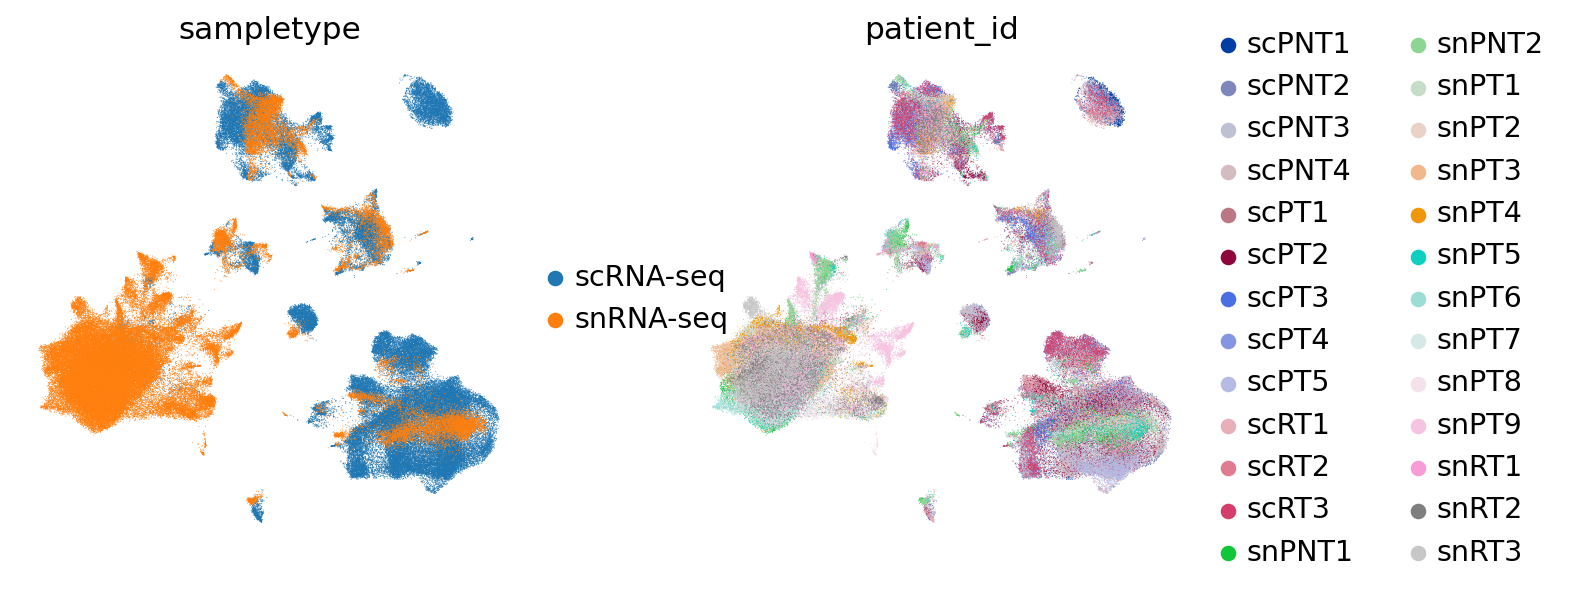

In [4]:
sc.pl.umap(adata, color=['sampletype', 'patient_id'], frameon=False, save='landscape_uncorrect.pdf')

In [27]:
# use the corrected cell embeddings from scvi
sc.pp.neighbors(adata, use_rep='X_scvi')
sc.tl.umap(adata, min_dist=0.5)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


In [29]:
# use integration with a label transfer assuming snRNA-seq data is unknown
adata.obs["celltype_scanvi"] = 'Unknown'
sc_mask = adata.obs['sampletype'] == "scRNA-seq"
adata.obs["celltype_scanvi"][sc_mask] = adata.obs.celltype[sc_mask].values

/tmp/ipykernel_168/1378811985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["celltype_scanvi"][sc_mask] = adata.obs.celltype[sc_mask].values


In [30]:
adata.obs

patient_id condition sampletype  nCount_RNA  \
PNT1_TAACCAGCATACACCA-1-0     scPNT1       PNT  scRNA-seq     91754.0   
PNT1_TACCTCGTCCTTCTAA-1-0     scPNT1       PNT  scRNA-seq     33903.0   
PNT1_ATAGACCAGCGGGTAT-1-0     scPNT1       PNT  scRNA-seq     18492.0   
PNT1_CTTTCAACACGATTCA-1-0     scPNT1       PNT  scRNA-seq     17989.0   
PNT1_AGCGTATAGCAGAAAG-1-0     scPNT1       PNT  scRNA-seq     11255.0   
...                              ...       ...        ...         ...   
RT3_TCTCCGAAGTCATACC-1-1       snRT3        RT  snRNA-seq      1195.0   
RT3_GCGGATCGTTGAGTCT-1-1       snRT3        RT  snRNA-seq      1580.0   
RT3_GTTACCCGTGGATGAC-1-1       snRT3        RT  snRNA-seq      1554.0   
RT3_AGAAGCGTCCCGTGTT-1-1       snRT3        RT  snRNA-seq      1712.0   
RT3_CTCTCAGAGAGATCGC-1-1       snRT3        RT  snRNA-seq      1938.0   

                           nFeature_RNA  mt_ratio  ribo_ratio   S.Score  \
PNT1_TAACCAGCATACACCA-1-0          8396  6.402627   15.758704 -0.091475   
PNT1_TACCTCGTCCTTCTAA-1-0          5426  1.430668    7.852366 -0.069337   
PNT1_ATAGACCAGCGGGTAT-1-0          3325  0.533521    8.555035 -0.026358   
PNT1_CTTTCAACACGATTCA-1-0          3118  0.856114    8.614156 -0.113612   
PNT1_AGCGTATAGCAGAAAG-1-0          1939  0.685065    7.826993 -0.061976   
...                                 ...       ...         ...       ...   
RT3_TCTCCGAAGTCATACC-1-1            452  1.972062   15.201315 -0.069032   
RT3_GCGGATCGTTGAGTCT-1-1           1129  0.766962    0.412979 -0.048837   
RT3_GTTACCCGTGGATGAC-1-1           1068  2.726146    0.000000  0.041134   
RT3_AGAAGCGTCCCGTGTT-1-1           1153  3.353829    0.223589  0.100996   
RT3_CTCTCAGAGAGATCGC-1-1           1412  0.412844    0.550459 -0.060910   

                           G2M.Score Phase          celltype  stress_ratio  \
PNT1_TAACCAGCATACACCA-1-0  -0.114883    G1       Hepatocytes     13.126403   
PNT1_TACCTCGTCCTTCTAA-1-0  -0.054674    G1       Plasma cell      8.332596   
PNT1_ATAGACCAGCGGGTAT-1-0  -0.125626    G1       Plasma cell      4.807484   
PNT1_CTTTCAACACGATTCA-1-0  -0.102579    G1       Plasma cell      1.083996   
PNT1_AGCGTATAGCAGAAAG-1-0  -0.082380    G1       Plasma cell      1.021768   
...                              ...   ...               ...           ...   
RT3_TCTCCGAAGTCATACC-1-1   -0.017565    G1       Hepatocytes      0.418410   
RT3_GCGGATCGTTGAGTCT-1-1   -0.092640    G1         T/NK cell      0.189873   
RT3_GTTACCCGTGGATGAC-1-1   -0.092658     S  Endothelial cell      0.000000   
RT3_AGAAGCGTCCCGTGTT-1-1   -0.093497     S  Endothelial cell      0.350467   
RT3_CTCTCAGAGAGATCGC-1-1    0.008544   G2M       Hepatocytes      0.051600   

                          batch  _scvi_batch  _scvi_labels celltype_scanvi  
PNT1_TAACCAGCATACACCA-1-0     0            0             0     Hepatocytes  
PNT1_TACCTCGTCCTTCTAA-1-0     0            0             0     Plasma cell  
PNT1_ATAGACCAGCGGGTAT-1-0     0            0             0     Plasma cell  
PNT1_CTTTCAACACGATTCA-1-0     0            0             0     Plasma cell  
PNT1_AGCGTATAGCAGAAAG-1-0     0            0             0     Plasma cell  
...                         ...          ...           ...             ...  
RT3_TCTCCGAAGTCATACC-1-1      1            0             0         Unknown  
RT3_GCGGATCGTTGAGTCT-1-1      1            0             0         Unknown  
RT3_GTTACCCGTGGATGAC-1-1      1            0             0         Unknown  
RT3_AGAAGCGTCCCGTGTT-1-1      1            0             0         Unknown  
RT3_CTCTCAGAGAGATCGC-1-1      1            0             0         Unknown  

[171253 rows x 16 columns]

In [31]:
# Integration with scANVI
lvae = scvi.model.SCANVI.from_scvi_model(model, adata=adata, labels_key='celltype_scanvi', unlabeled_category='Unknown')

In [38]:
lvae.train()

INFO     Training for 10 epochs.                                                             


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|███████████████████████████████████████████████████| 10/10 [03:30<00:00, 20.74s/it, loss=625, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|███████████████████████████████████████████████████| 10/10 [03:30<00:00, 21.02s/it, loss=625, v_num=1]


In [39]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [40]:
adata.layers['scANVI_normalized'] = lvae.get_normalized_expression(library_size=10e4)

In [41]:
sc.pp.neighbors(adata, use_rep='X_scANVI')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [42]:
sc.tl.umap(adata, min_dist=0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:00)


In [34]:
adata.write("adata_integration.h5ad")

In [3]:
adata = sc.read_h5ad("adata_integration.h5ad")

In [17]:
# create a integration cluster
adata.obs['int_clusters'] = (
    adata.obs["new_clusters_2"]
    .map(lambda x: {"B cells": "B cells", "CAF": "CAF", "Cycling cells_H": "Cycling cells", "Cycling cells_M": "Cycling cells", "Cycling cells_T": "Cycling cells", "Endothelial cells": "Endothelial cells", "Hepatocytes": "Hepatocytes", "Myeloid cells": "Myeloid cells", "NK cells": "NK cells", "Neutrophils": "Neutrophils", "Plasma cells": "Plasma cells", "T cells": "T cells"}.get(x, x))
    .astype("category")
)
# this expression, from github, is very useful for reassignment of certain variables in dataframe

In [51]:
adata

AnnData object with n_obs × n_vars = 171253 × 2000
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'stress_ratio', 'batch', '_scvi_batch', '_scvi_labels', 'scanvi_leiden', 'new_clusters', 'new_clusters_2', 'int_clusters'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'condition_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'new_clusters_2_colors', 'new_clusters_colors', 'patient_id_colors', 'pca', 'rank_genes_groups', 'sampletype_colors', 'scanvi_leiden_colors', 'umap', 'int_clusters_colors'
    obsm: 'X_harmony', 'X_pca', 'X_scANVI', 'X

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


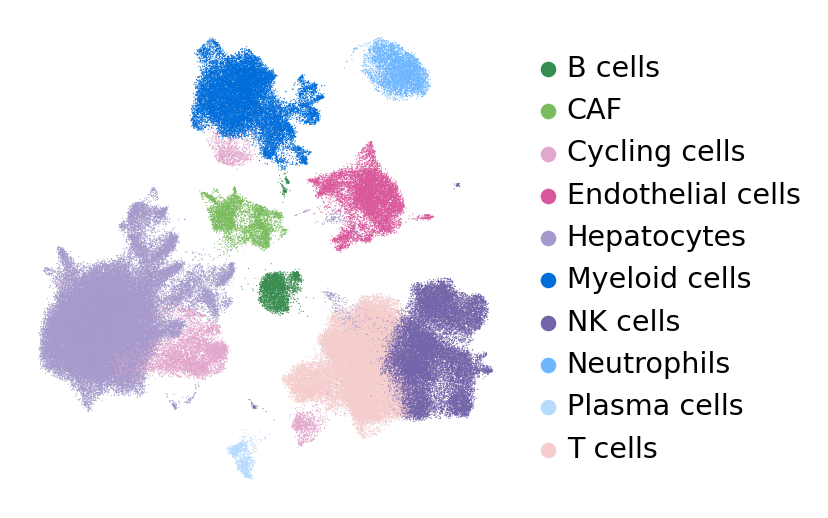

In [50]:
sc.pl.umap(
    adata,
    color=['int_clusters'],
    palette=palette_d, 
    frameon=False,
    s=1,
    title='',
    save = '_landscape.pdf'
)

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


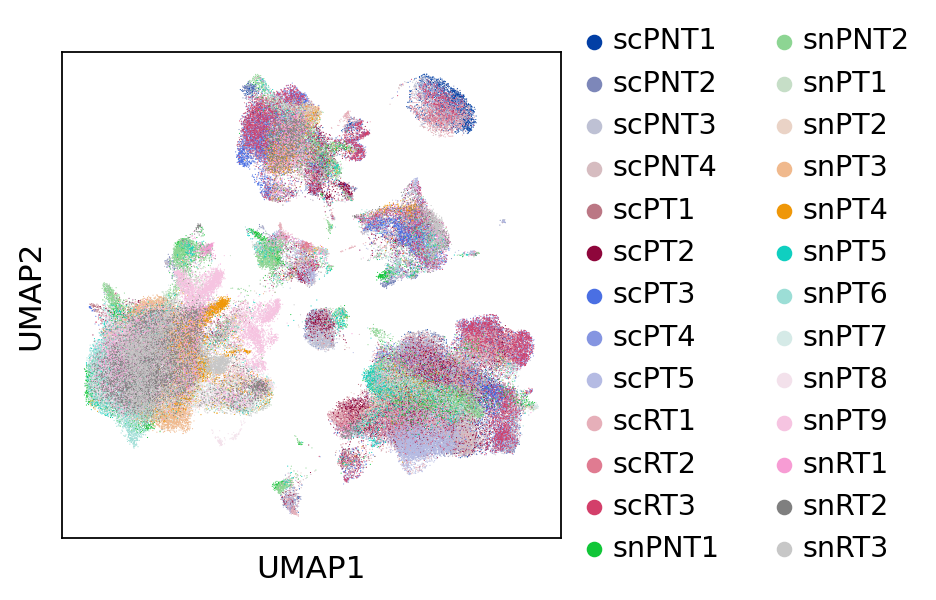

In [55]:
sc.pl.umap(adata, color=['patient_id'], frameon=True, title='', s=1, save = '_patient_id.pdf')

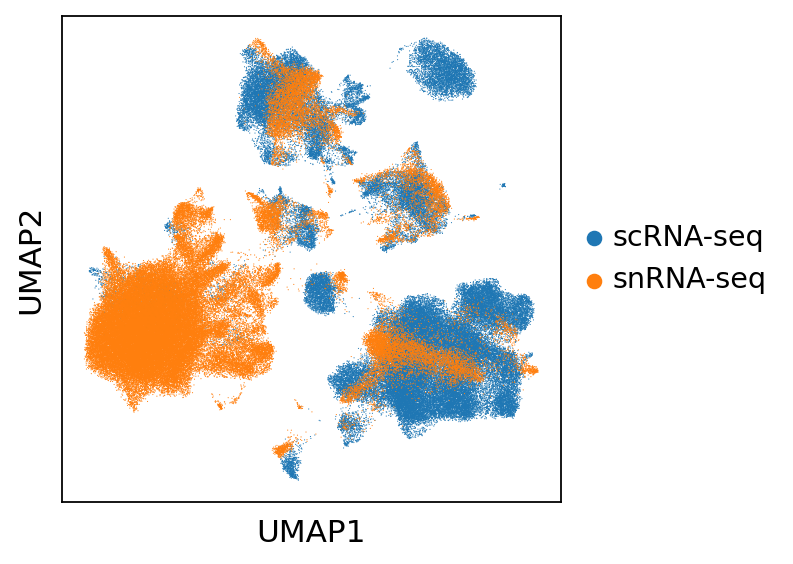

In [57]:
sc.pl.umap(adata, color = ['sampletype'], frameon=True, title = '', s=1, save='_technique.pdf')

In [60]:
# set dataset 
adata.obs['dataset'] = (
    adata.obs["patient_id"]
    .map(lambda x: {"scPNT1": "'in-house", "scPNT2": "'in-house", "scPNT3": "'in-house", "scPNT3": "'in-house","scPNT4": "'in-house", "scPT1": "'in-house", "scPT2": "'in-house", "scPT3": "'in-house", "scPT4": "'in-house", "scPT5": "'in-house", "scRT1": "'in-house", "scRT2": "'in-house", "scRT3": "'in-house", "snPNT1": "others","snPNT2": "others","snPT1": "'in-house","snPT2": "'in-house","snPT3": "'in-house","snPT4": "'in-house","snPT5": "'in-house","snPT6": "'in-house","snPT7": "'in-house","snPT8": "'in-house","snPT9": "'in-house","snRT1": "'in-house", "snRT2": "'in-house", "snRT3": "'in-house"}.get(x, x))
    .astype("category")
)

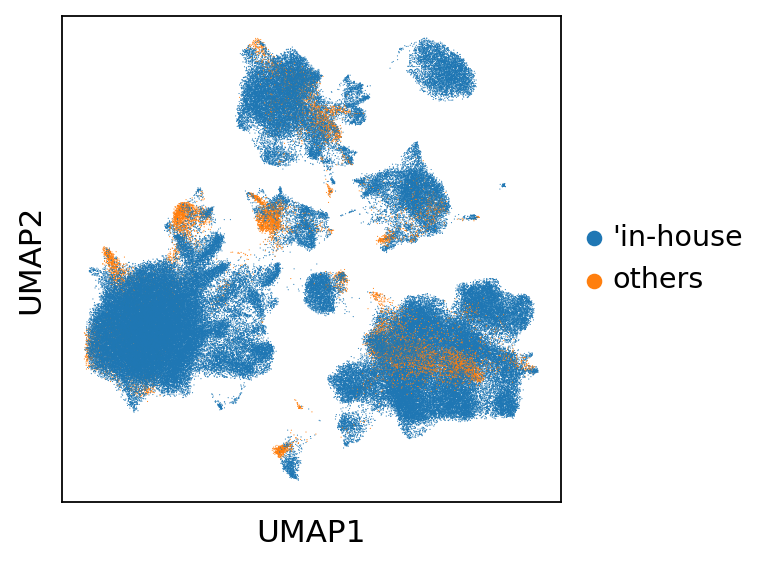

In [62]:
sc.pl.umap(adata, color = ['dataset'], frameon=True, title = '', s=1, save = '_dataset.pdf')

In [64]:
adata.obs.condition.unique()

['PNT', 'PT', 'RT']
Categories (3, object): ['PNT', 'PT', 'RT']

In [65]:
# modify condition
adata.obs['condition_m'] = (
    adata.obs["condition"]
    .map(lambda x: {"PNT": "adjancant normal", "PT": "tumor", "RT": "tumor"}.get(x, x))
    .astype("category")
)

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


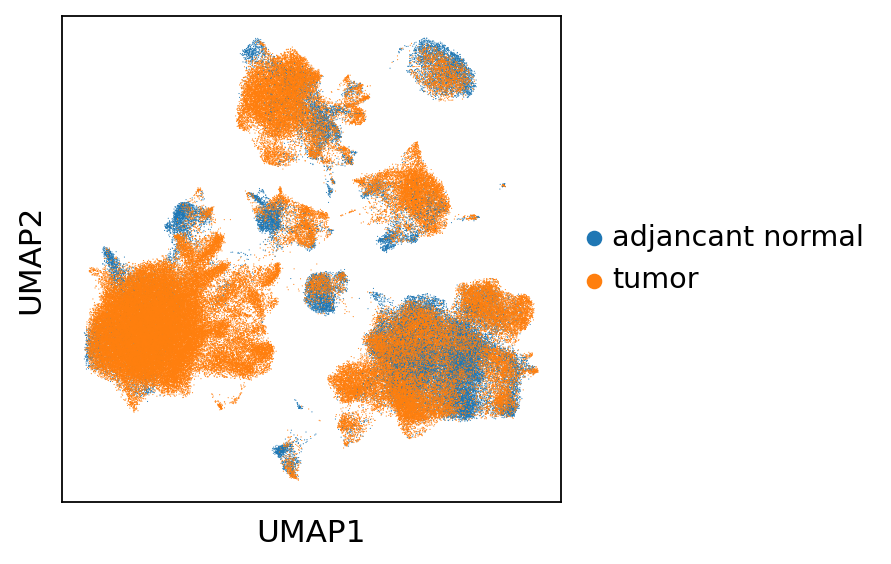

In [67]:
sc.pl.umap(adata, color = ['condition_m'], frameon=True, title = '', s=1, save='_condition.pdf')

In [68]:
# save the good result
adata.write('adata_integration.h5ad')

In [3]:
# cluster and re-annotation
adata = scvi.data.read_h5ad('adata_integration.h5ad')

In [17]:
adata

AnnData object with n_obs × n_vars = 171253 × 2000
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'stress_ratio', 'batch', '_scvi_batch', '_scvi_labels', 'scanvi_leiden', 'new_clusters'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'condition_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'new_clusters_colors', 'patient_id_colors', 'pca', 'rank_genes_groups', 'sampletype_colors', 'scanvi_leiden_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_scANVI', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
  

In [7]:
sc.tl.leiden(adata, resolution=1.2, key_added='scanvi_leiden')

running Leiden clustering
    finished: found 34 clusters and added
    'scanvi_leiden', the cluster labels (adata.obs, categorical) (0:01:37)


In [10]:
# Annotation
adata.obs['new_clusters'] = (
    adata.obs["scanvi_leiden"]
    .map(lambda x: {"0": "Hepatocytes", "1": "Myeloid cells", "2": "Hepatocytes", "3": "T cells", "4": "T cells", "5": "T cells", "6": "NK cells", "7": "Endothelial cells", "8": "NK cells", "9": "Cycling cells", "10": "T cells", "11": "NK cells", "12": "Hepatocytes", "13": "Neutrophils", "14": "CAF", "15": "Hepatocytes", "16": "Myeloid cells", "17": "B cells", "18": "Hepatocytes", "19": "Hepatocytes", "20": "Hepatocytes", "21": "Myeloid cells", "22": "Hepatocytes", "23": "Plasma cells", "24": "Cycling cells", "25": "Endothelial cells", "26": "Cycling cells", "27": "Cycling cells", "28": "NK cells", "29": "NK cells", "30": "Hepatocytes", "31": "Endothelial cells"}.get(x, x))
    .astype("category")
)
# this expression, from github, is very useful for reassignment of certain variables in dataframe

In [69]:
# Marker visualization
markers = {
    'B cells': ['CD79A', 'BANK1'], 
    'CAF': ['PDGFRB', 'TAGLN'], 
    'Cycling cells': ['MKI67', 'TOP2A'], 
    'Endothelial cells': ['CD34', 'PECAM1'], 
    'Hepatocytes': ['APOB', 'TF'], 
    'Myeloid cells': ['C1QB', 'LYZ'], 
    'NK cells': ['XCL1', 'KLRC2'], 
    'Neutrophils': ['OSM', 'HCAR3'], 
    'Plasma cells': ['JCHAIN', 'MZB1'],  
    'T cells': ['IL7R', 'IL2']
}

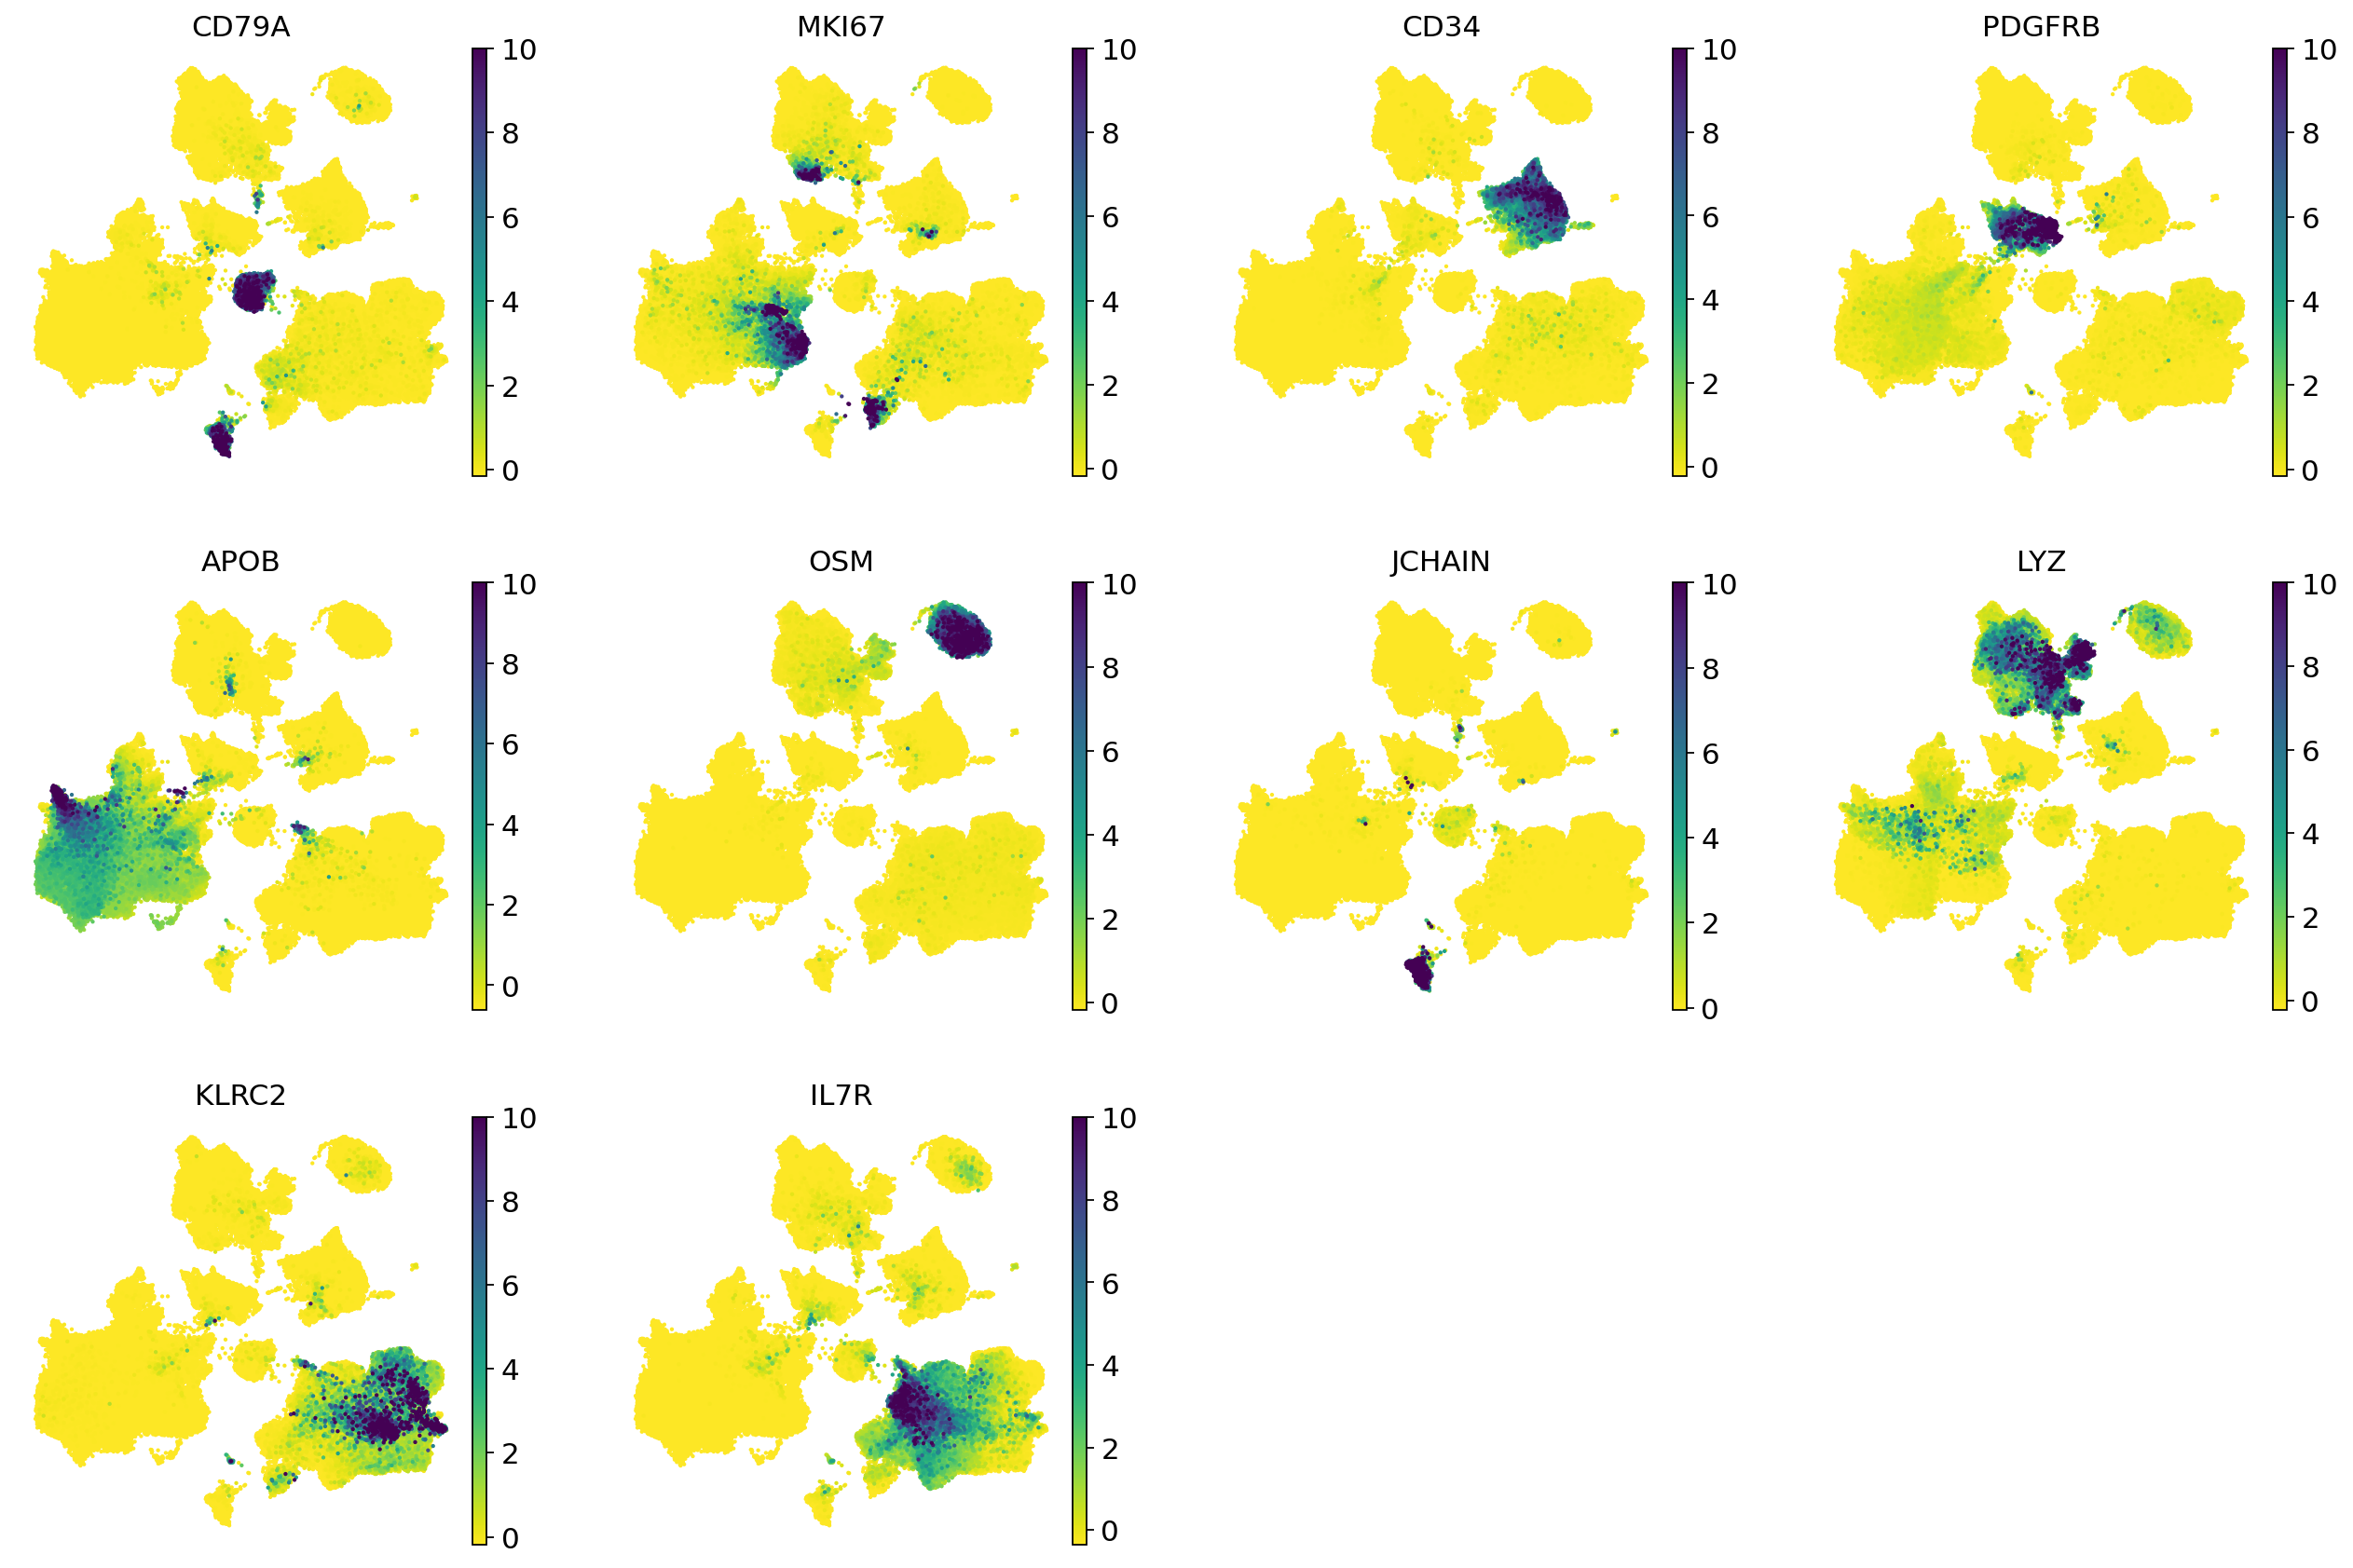

In [79]:
sc.pl.umap(adata, color=['CD79A', 'MKI67', 'CD34', 'PDGFRB', 'APOB', 'OSM', 'JCHAIN', 'LYZ', 'KLRC2', 'IL7R'], s=15, frameon=False, layer='scANVI_scaled')

In [37]:
x = adata.layers['scANVI_normalized']
x

array([[        nan,  0.1736114 ,  0.2687536 , ..., -0.26560396,
        -0.44306663,  0.46516776],
       [        nan,  1.0045422 ,  0.91532946, ...,  0.12051025,
        -0.45477995, -0.17470245],
       [        nan,  0.70259714,  0.52013427, ...,  0.01418949,
        -0.46518832, -0.27358946],
       ...,
       [        nan,  0.02873066,  0.9212188 , ..., -0.26705152,
         0.07538681, -0.30248386],
       [        nan,  0.01566454,  0.93390596, ..., -0.24636348,
        -0.16327849, -0.188168  ],
       [        nan, -1.3143743 , -1.399251  , ..., -0.26060846,
        -0.40777326, -0.3253796 ]], dtype=float32)

In [5]:
adata = sc.read_h5ad("adata_integration.h5ad")

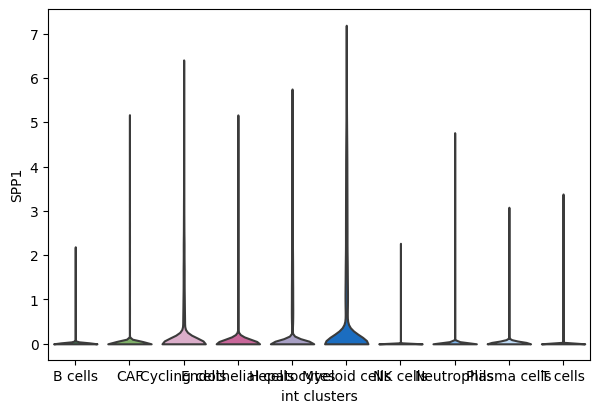

In [15]:
sc.pl.violin(adata,"SPP1", groupby="int_clusters", size=0, use_raw=False)

In [9]:
adata.obs.int_clusters.unique()

['Hepatocytes', 'Plasma cells', 'Myeloid cells', 'Cycling cells', 'Endothelial cells', 'B cells', 'NK cells', 'T cells', 'CAF', 'Granulocytes']
Categories (10, object): ['B cells', 'CAF', 'Cycling cells', 'Endothelial cells', ..., 'NK cells', 'Granulocytes', 'Plasma cells', 'T cells']

In [10]:
# Marker visualization
markers = {
    'B cells': ['CD79A', 'BANK1'], 
    'CAF': ['PDGFRB', 'TAGLN'], 
    'Cycling cells': ['MKI67', 'TOP2A'], 
    'Endothelial cells': ['CD34', 'PECAM1'], 
    'Hepatocytes': ['APOB', 'TF', 'HNF4A'], 
    'Myeloid cells': ['C1QB', 'LYZ'], 
    'NK cells': ['NKG7', 'KLRB1'], 
    'Granulocytes': ['OSM', 'HCAR3'], 
    'Plasma cells': ['JCHAIN', 'MZB1'],  
    'T cells': ['IL7R', 'CD3D']
}

/home/chutianhao/.conda/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


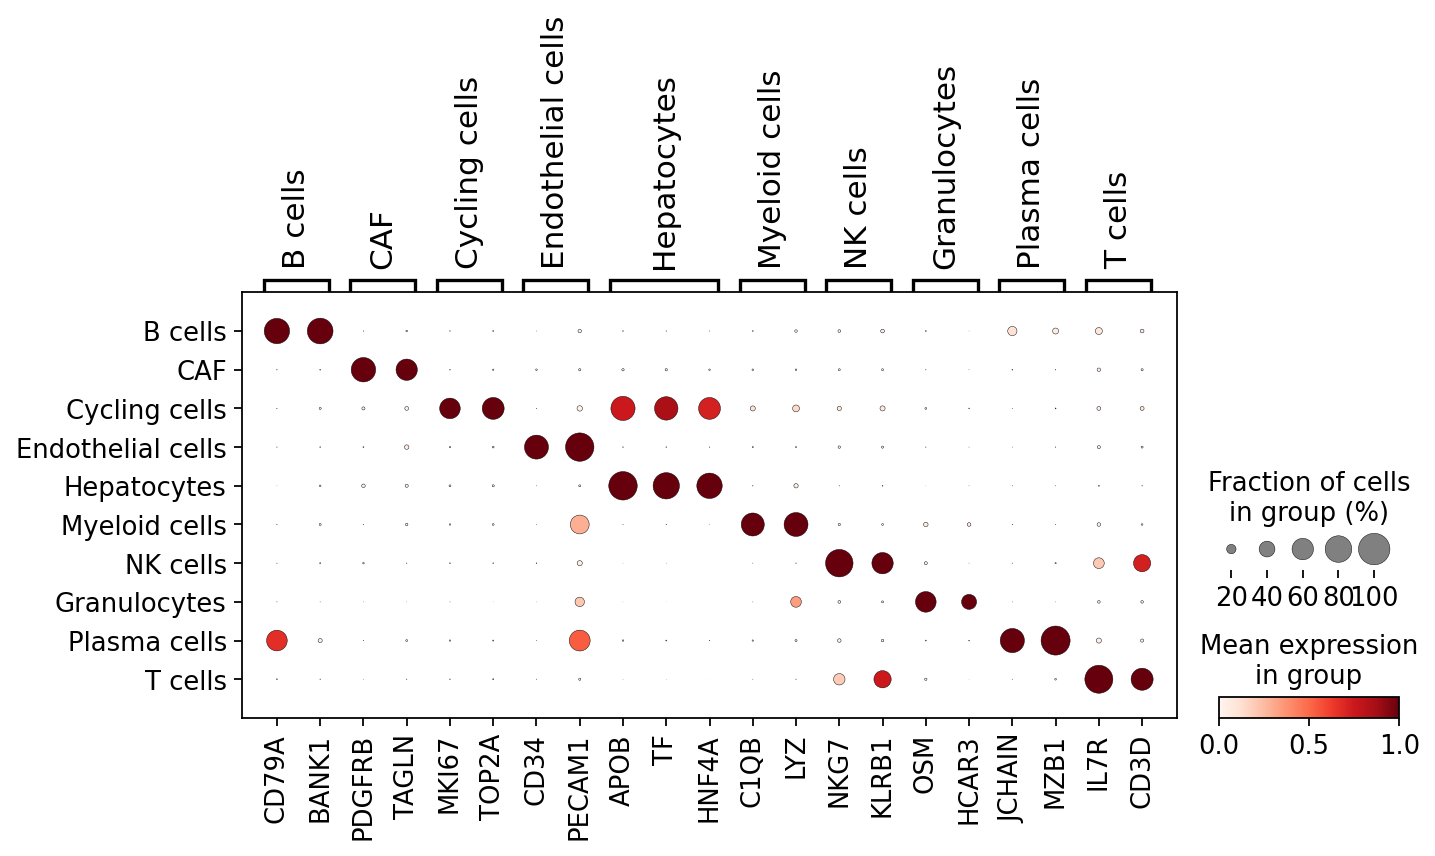

In [11]:
sc.pl.dotplot(adata, markers, 'int_clusters', color_map='Reds', use_raw=True, standard_scale='var')

In [25]:
adata.write('adata_integration.h5ad')

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


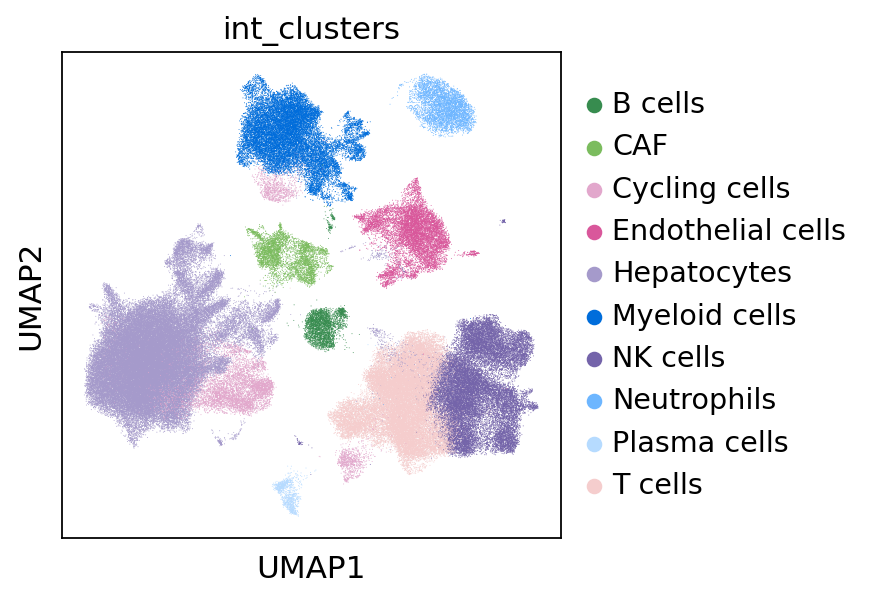

In [4]:
sc.pl.umap(adata, color=['int_clusters'])

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


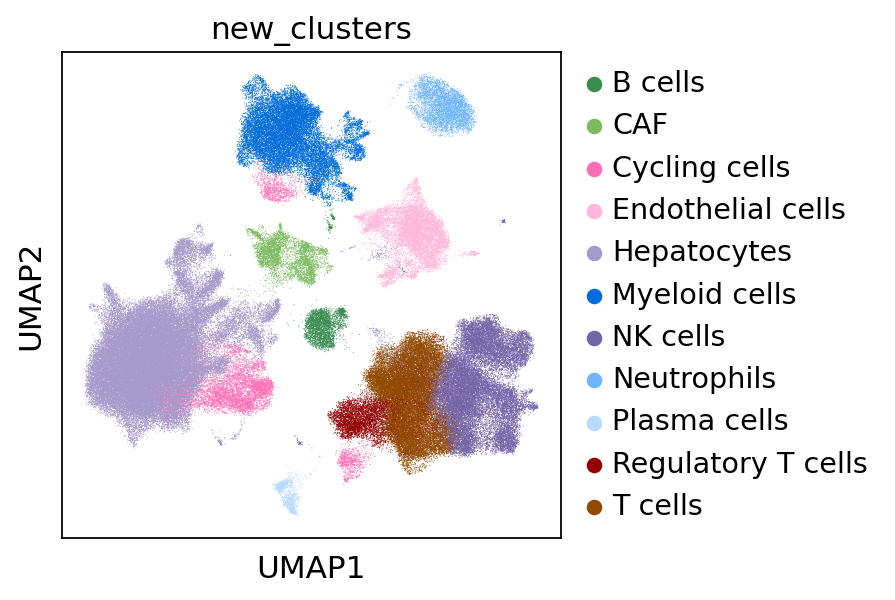

In [7]:
sc.pl.umap(adata, color=["new_clusters"])

In [8]:
df = adata.obs.copy()

In [11]:
df.drop(labels=["new_clusters"], axis=1, inplace=True)

In [12]:
df.drop(labels=["condition", "stress_ratio", "_scvi_batch", "_scvi_labels", "scanvi_leiden"], axis=1, inplace=True)

In [14]:
df.drop(labels=["batch", "celltype"], axis=1, inplace=True)

In [19]:
df.rename({"condition_m": "condition", "new_clusters_2": "clusters_2", "int_clusters": "clusters"}, axis=1, inplace=True)

In [20]:
df

patient_id sampletype  nCount_RNA  nFeature_RNA   
PNT1_TAACCAGCATACACCA-1-0     scPNT1  scRNA-seq     91754.0          8396  \
PNT1_TACCTCGTCCTTCTAA-1-0     scPNT1  scRNA-seq     33903.0          5426   
PNT1_ATAGACCAGCGGGTAT-1-0     scPNT1  scRNA-seq     18492.0          3325   
PNT1_CTTTCAACACGATTCA-1-0     scPNT1  scRNA-seq     17989.0          3118   
PNT1_AGCGTATAGCAGAAAG-1-0     scPNT1  scRNA-seq     11255.0          1939   
...                              ...        ...         ...           ...   
RT3_TCTCCGAAGTCATACC-1-1       snRT3  snRNA-seq      1195.0           452   
RT3_GCGGATCGTTGAGTCT-1-1       snRT3  snRNA-seq      1580.0          1129   
RT3_GTTACCCGTGGATGAC-1-1       snRT3  snRNA-seq      1554.0          1068   
RT3_AGAAGCGTCCCGTGTT-1-1       snRT3  snRNA-seq      1712.0          1153   
RT3_CTCTCAGAGAGATCGC-1-1       snRT3  snRNA-seq      1938.0          1412   

                           mt_ratio  ribo_ratio   S.Score  G2M.Score Phase   
PNT1_TAACCAGCATACACCA-1-0  6.402627   15.758704 -0.091475  -0.114883    G1  \
PNT1_TACCTCGTCCTTCTAA-1-0  1.430668    7.852366 -0.069337  -0.054674    G1   
PNT1_ATAGACCAGCGGGTAT-1-0  0.533521    8.555035 -0.026358  -0.125626    G1   
PNT1_CTTTCAACACGATTCA-1-0  0.856114    8.614156 -0.113612  -0.102579    G1   
PNT1_AGCGTATAGCAGAAAG-1-0  0.685065    7.826993 -0.061976  -0.082380    G1   
...                             ...         ...       ...        ...   ...   
RT3_TCTCCGAAGTCATACC-1-1   1.972062   15.201315 -0.069032  -0.017565    G1   
RT3_GCGGATCGTTGAGTCT-1-1   0.766962    0.412979 -0.048837  -0.092640    G1   
RT3_GTTACCCGTGGATGAC-1-1   2.726146    0.000000  0.041134  -0.092658     S   
RT3_AGAAGCGTCCCGTGTT-1-1   3.353829    0.223589  0.100996  -0.093497     S   
RT3_CTCTCAGAGAGATCGC-1-1   0.412844    0.550459 -0.060910   0.008544   G2M   

                                  clusters_2           clusters    dataset   
PNT1_TAACCAGCATACACCA-1-0        Hepatocytes        Hepatocytes  'in-house  \
PNT1_TACCTCGTCCTTCTAA-1-0       Plasma cells       Plasma cells  'in-house   
PNT1_ATAGACCAGCGGGTAT-1-0       Plasma cells       Plasma cells  'in-house   
PNT1_CTTTCAACACGATTCA-1-0       Plasma cells       Plasma cells  'in-house   
PNT1_AGCGTATAGCAGAAAG-1-0       Plasma cells       Plasma cells  'in-house   
...                                      ...                ...        ...   
RT3_TCTCCGAAGTCATACC-1-1         Hepatocytes        Hepatocytes  'in-house   
RT3_GCGGATCGTTGAGTCT-1-1             T cells            T cells  'in-house   
RT3_GTTACCCGTGGATGAC-1-1   Endothelial cells  Endothelial cells  'in-house   
RT3_AGAAGCGTCCCGTGTT-1-1   Endothelial cells  Endothelial cells  'in-house   
RT3_CTCTCAGAGAGATCGC-1-1         Hepatocytes        Hepatocytes  'in-house   

                                  condition  
PNT1_TAACCAGCATACACCA-1-0  adjancant normal  
PNT1_TACCTCGTCCTTCTAA-1-0  adjancant normal  
PNT1_ATAGACCAGCGGGTAT-1-0  adjancant normal  
PNT1_CTTTCAACACGATTCA-1-0  adjancant normal  
PNT1_AGCGTATAGCAGAAAG-1-0  adjancant normal  
...                                     ...  
RT3_TCTCCGAAGTCATACC-1-1              tumor  
RT3_GCGGATCGTTGAGTCT-1-1              tumor  
RT3_GTTACCCGTGGATGAC-1-1              tumor  
RT3_AGAAGCGTCCCGTGTT-1-1              tumor  
RT3_CTCTCAGAGAGATCGC-1-1              tumor  

[171253 rows x 13 columns]

In [23]:
cols2 = ["patient_id", "sampletype", "condition", "dataset", "nCount_RNA", "nFeature_RNA", "mt_ratio", "ribo_ratio", "S.Score", "G2M.Score", "Phase", "clusters", "clusters_2"]

In [24]:
df = df[cols2]

In [26]:
adata.obs = df.copy()

In [27]:
adata.obs

patient_id sampletype         condition    dataset   
PNT1_TAACCAGCATACACCA-1-0     scPNT1  scRNA-seq  adjancant normal  'in-house  \
PNT1_TACCTCGTCCTTCTAA-1-0     scPNT1  scRNA-seq  adjancant normal  'in-house   
PNT1_ATAGACCAGCGGGTAT-1-0     scPNT1  scRNA-seq  adjancant normal  'in-house   
PNT1_CTTTCAACACGATTCA-1-0     scPNT1  scRNA-seq  adjancant normal  'in-house   
PNT1_AGCGTATAGCAGAAAG-1-0     scPNT1  scRNA-seq  adjancant normal  'in-house   
...                              ...        ...               ...        ...   
RT3_TCTCCGAAGTCATACC-1-1       snRT3  snRNA-seq             tumor  'in-house   
RT3_GCGGATCGTTGAGTCT-1-1       snRT3  snRNA-seq             tumor  'in-house   
RT3_GTTACCCGTGGATGAC-1-1       snRT3  snRNA-seq             tumor  'in-house   
RT3_AGAAGCGTCCCGTGTT-1-1       snRT3  snRNA-seq             tumor  'in-house   
RT3_CTCTCAGAGAGATCGC-1-1       snRT3  snRNA-seq             tumor  'in-house   

                           nCount_RNA  nFeature_RNA  mt_ratio  ribo_ratio   
PNT1_TAACCAGCATACACCA-1-0     91754.0          8396  6.402627   15.758704  \
PNT1_TACCTCGTCCTTCTAA-1-0     33903.0          5426  1.430668    7.852366   
PNT1_ATAGACCAGCGGGTAT-1-0     18492.0          3325  0.533521    8.555035   
PNT1_CTTTCAACACGATTCA-1-0     17989.0          3118  0.856114    8.614156   
PNT1_AGCGTATAGCAGAAAG-1-0     11255.0          1939  0.685065    7.826993   
...                               ...           ...       ...         ...   
RT3_TCTCCGAAGTCATACC-1-1       1195.0           452  1.972062   15.201315   
RT3_GCGGATCGTTGAGTCT-1-1       1580.0          1129  0.766962    0.412979   
RT3_GTTACCCGTGGATGAC-1-1       1554.0          1068  2.726146    0.000000   
RT3_AGAAGCGTCCCGTGTT-1-1       1712.0          1153  3.353829    0.223589   
RT3_CTCTCAGAGAGATCGC-1-1       1938.0          1412  0.412844    0.550459   

                            S.Score  G2M.Score Phase           clusters   
PNT1_TAACCAGCATACACCA-1-0 -0.091475  -0.114883    G1        Hepatocytes  \
PNT1_TACCTCGTCCTTCTAA-1-0 -0.069337  -0.054674    G1       Plasma cells   
PNT1_ATAGACCAGCGGGTAT-1-0 -0.026358  -0.125626    G1       Plasma cells   
PNT1_CTTTCAACACGATTCA-1-0 -0.113612  -0.102579    G1       Plasma cells   
PNT1_AGCGTATAGCAGAAAG-1-0 -0.061976  -0.082380    G1       Plasma cells   
...                             ...        ...   ...                ...   
RT3_TCTCCGAAGTCATACC-1-1  -0.069032  -0.017565    G1        Hepatocytes   
RT3_GCGGATCGTTGAGTCT-1-1  -0.048837  -0.092640    G1            T cells   
RT3_GTTACCCGTGGATGAC-1-1   0.041134  -0.092658     S  Endothelial cells   
RT3_AGAAGCGTCCCGTGTT-1-1   0.100996  -0.093497     S  Endothelial cells   
RT3_CTCTCAGAGAGATCGC-1-1  -0.060910   0.008544   G2M        Hepatocytes   

                                  clusters_2  
PNT1_TAACCAGCATACACCA-1-0        Hepatocytes  
PNT1_TACCTCGTCCTTCTAA-1-0       Plasma cells  
PNT1_ATAGACCAGCGGGTAT-1-0       Plasma cells  
PNT1_CTTTCAACACGATTCA-1-0       Plasma cells  
PNT1_AGCGTATAGCAGAAAG-1-0       Plasma cells  
...                                      ...  
RT3_TCTCCGAAGTCATACC-1-1         Hepatocytes  
RT3_GCGGATCGTTGAGTCT-1-1             T cells  
RT3_GTTACCCGTGGATGAC-1-1   Endothelial cells  
RT3_AGAAGCGTCCCGTGTT-1-1   Endothelial cells  
RT3_CTCTCAGAGAGATCGC-1-1         Hepatocytes  

[171253 rows x 13 columns]

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


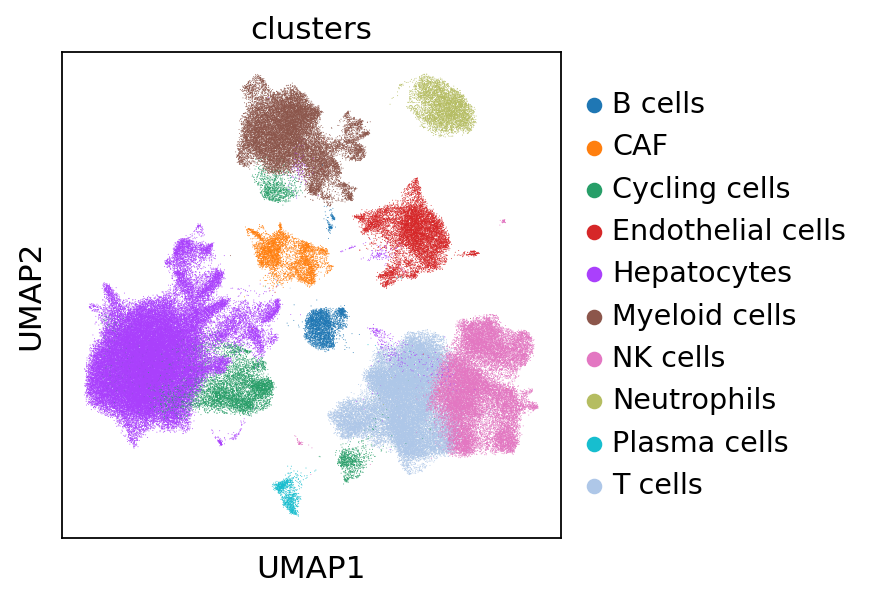

In [28]:
sc.pl.umap(adata, color=["clusters"])

In [3]:
adata = sc.read_h5ad("adata_integration.h5ad")

In [4]:
adata.layers["counts"]

<171253x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 41220105 stored elements in Compressed Sparse Row format>

In [5]:
adata_raw = adata_sc.concatenate(adata_sn)

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
adata_raw

AnnData object with n_obs × n_vars = 171253 × 16294
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'ribo_ratio', 'S.Score', 'G2M.Score', 'Phase', 'celltype', 'stress_ratio', 'batch'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [7]:
adata_raw.write("adata_integration_raw.h5ad")